<center><b>Sentiment Analysis using CNN architecture</b></center>

<ul>
    <li>The dataset can be downloaded at <a href="https://nlp.stanford.edu/sentiment">https://nlp.stanford.edu/sentiment</a> under Dataset Download -> Main zip file with readme (6mb).</li>
    <li>The polarity data can be downloaded from <a href="http://www.cs.cornell.edu/people/pabo/movie-review-data">http://www.cs.cornell.edu/people/pabo/movie-review-data</a> under Sentiment polarity datasets.</li>
</ul>

<b>Architecture:</b>
<br>
The CNN architecture described in <a href="https://arxiv.org/pdf/1408.5882.pdf">Kim, Y. (2014)</a> is used for the sentiment analysis task.

In [24]:
import os
import urllib
import zipfile
import nltk
import re
import numpy as np
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

from numpy import array
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, concatenate, Dropout
from tensorflow.keras import regularizers

<b>Loading the Glove embedding of 300 dimension size</b>

In [2]:
#Loading Glove model

def loadGloveModel(gloveFile):
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    f.close()
    return model

print("Loading Glove Model of 300 dimensions")
gloveModel = loadGloveModel("glove.6B.300d.txt")

Loading Glove Model of 300 dimensions
Done. 400000  words loaded!


<b>Loading the train/test/dev split from file as a dictionary object for easier lookup</b>

In [3]:
datasetSplitFile = 'stanfordSentimentTreebank\stanfordSentimentTreebank\datasetSplit.txt'
def produceSplit(data, datasetSplitFile):
    splitMap = {}
    f = open(datasetSplitFile, 'r')
    next(f)
    count = 0
    for line in f:
        line = line.strip()
        stmtid, dataType = line.split(',')
        splitMap[int(stmtid)] = int(dataType)
    f.close()
    return splitMap
    
splitMap = produceSplit(None, datasetSplitFile)
print("Length:", len(splitMap))

Length: 11855


<b>Mapping the reviews to their positive/negative labels</b>

In [4]:
dataFile = "stanfordSentimentTreebank\\stanfordSentimentTreebank\\original_rt_snippets.txt"
positiveLabels = "rt-polaritydata\\rt-polarity.pos"
negativeLabels = "rt-polaritydata\\rt-polarity.neg"
sentenceDataFile = "stanfordSentimentTreebank\\stanfordSentimentTreebank\\datasetSentences.txt"

In [5]:
#Method to perform text processing to convert positive/negative snippets to format matching the original rt review text
def getTransformedReview(line):
    line = line.lower()
    line = line.strip()
    line = line.replace(' . ', '').replace('. ', '').replace(' .', '').replace('.', '').replace("… ", '').replace("…", '')
    line = line.replace(' , ', ', ').replace(' :', ':').replace(' ;', ';').replace('( ', '').replace(' )', '').replace('[', '')
    line = line.replace(' ]', '').replace('] ', ' ').replace(']', '').replace(' \"', '').replace('\" ', '').replace('\"', '')
    line = line.replace('\'', '').replace(' ? s', 's').replace(' ?', '').replace('? ', '').replace('?', '').replace(' ! ', ' ')
    line = line.replace(' !', '').replace('! ', '').replace('!', '').replace("<b>", '').replace("</b>", '').replace("<em>", '')
    line = line.replace("</em>", '').replace('`', '').replace('—', '--').replace("  ", " ")
    return line.strip()

#Method to extract the positive and negative labelled reviews
def populateLabelFiles(posFile, negFile):
    positiveFile = open(posFile, 'r')
    posRev = []
    for line in positiveFile:
        line = getTransformedReview(line)
        posRev.append(line[:20])
    positiveFile.close()
    
    negativeFile = open(negFile, 'r')
    negRev = []
    for line in negativeFile:
        line = getTransformedReview(line)
        negRev.append(line[:20])
    negativeFile.close()
    return posRev, negRev

#Method to perform text processing to convert original rt reviews to format matching the positive/negative review snippets
def getTransformedLine(line):
    refLine = line.lower()
    refLine = refLine.replace('(', '').replace(')c', ' c').replace(')', '').replace("``", '').replace("''", '').replace("’", '')
    refLine = refLine.replace(' . ', '').replace('. ', '').replace(' .', '').replace('.', '').replace(' , ', ', ')
    refLine = refLine.replace("  ", " ").replace(" \'s ", 's ').replace(' \'d ', 'd ').replace('\'', '').replace('\/', '/')
    refLine = refLine.replace("?", "").replace("!", "").replace('`', '')
    refLine = refLine.strip()
    return refLine

#Method to read and populate the data and its corresponding labels for the RT reviews
def readData(dataFile, posFile, negFile):
    dataFilePointer = open(dataFile, 'r', encoding="utf8")
    count = 0
    dataset = []
    dataLabels = []
    posReview, negReview = populateLabelFiles(posFile, negFile)
    for line in dataFilePointer:
        line = line.strip()
        refLine = getTransformedLine(line)
        
        #Additional pre-processing is done here to facilitate matching between reviews and statement wise data
        dataset.append(refLine.replace("--", "–").replace("½", "1/2").replace('\"', '').replace("–-", "–").replace(" ", ""))
        
        if refLine[:20] in posReview:
            dataLabels.append(1)
        elif refLine[:20] in negReview:
            dataLabels.append(0)
        else:
            print("Error")
            print(refLine)
            break
    dataFilePointer.close()
    return dataset, dataLabels
    
reviewData, reviewDataLabels = readData(dataFile, positiveLabels, negativeLabels)

<b>Processing the reviews:</b>
<ul>
    <li>The reviews in RT file are transformed to match the sentences in positive and negative files for matching purposes.</li>
    <li>The reviews are further pre-processed for matching the dataset sentences in the next step. The transformations were observed by iterative processing of the RT reviews, positive/negative and the dataset files.</li>
    <li>Regular Expressions were tried but due to the difference in the order of sentences between the RT reviews and the positive/negative, they weren't effective. Thus, explicit transformations in the required order were utilized.</li>
</ul>

In [6]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemma_str = ""
    for w in w_tokenizer.tokenize(text):
        lemma_str += lemmatizer.lemmatize(w) + " "
    return lemma_str

stopWords = set(stopwords.words('english'))

def remove_stop_words(text):
    return_str = ""
    for w in w_tokenizer.tokenize(text):
        if w not in stopWords:
            return_str += w + " "
    return return_str

In [7]:
#Method to get transformed statements to match the review statements
def getTransformedStmt(line):
    refLine = line.lower()
    
    #START punctuation transformation
    refLine = refLine.replace('(', '').replace(')c', ' c').replace(')', '').replace("``", '').replace("’", '')
    refLine = refLine.replace(' . ', '').replace('. ', '').replace(' .', '').replace('.', '').replace(' , ', ', ')
    refLine = refLine.replace("  ", " ").replace(" \'s ", 's ').replace(' \'d ', 'd ').replace('\'', '').replace('\/', '/')
    refLine = refLine.replace('\\', '').replace("?", "").replace("!", "").replace('`', '')
    refLine = refLine.strip()
    #END punctuation transformation
    
    refLine = refLine.replace("can not", "cannot").replace(" nt", "nt").replace("` ", '').replace(" '", '').replace(' ;', ';')
    refLine = refLine.replace(' :', ':').replace('-lrb- ', '').replace('-rrb- ', '').replace('-rrb-', '').replace(" -8", "-8")
    refLine = refLine.replace(' ,', ',').replace('ã©', 'é').replace('ã­', 'í').replace('ã¼', 'ü').replace('ã³', 'ó')
    refLine = refLine.replace('ã¡', 'á').replace('ã¦', 'æ').replace('ã', 'à').replace('â', '').replace('à¢', 'â')
    refLine = refLine.replace('à±', 'ñ').replace('à¯', 'ï').replace('à´', 'ô').replace('à¨', 'è').replace('à¶', 'ö')
    refLine = refLine.replace('à£', 'ã').replace('à»', 'û').replace('à§', 'ç').replace(' ', '').replace("--", "–")
    refLine = refLine.replace("--", "–").replace(' ', '')
    return refLine

#Method to get the clean version of the review statements for training/validation/testing
def getCleanedReview(refLine):
    refLine = refLine.replace("``", '').replace("’", '').replace('`', '')
    
    refLine = refLine.replace('-lrb- ', '').replace('-rrb- ', '').replace('-rrb-', '')
    
    refLine = refLine.replace('ã©', 'é').replace('ã­', 'í').replace('ã¼', 'ü').replace('ã³', 'ó').replace('ã¡', 'á')
    refLine = refLine.replace('ã¦', 'æ').replace('ã', 'à').replace('à¢', 'â').replace('à±', 'ñ').replace('à¯', 'ï')
    refLine = refLine.replace('à´', 'ô').replace('à¨', 'è').replace('à¶', 'ö').replace('à£', 'ã').replace('à»', 'û')
    refLine = refLine.replace('à§', 'ç')
    
    #return lemmatize_text(refLine)
    #return remove_stop_words(refLine)
    return refLine

#Method to match the statement in the review and obtain the corresponding label
def retLabel(reviewData, reviewDataLabels, line, i):
    searchLine = getTransformedStmt(line)
    indx = 0
    for entry in reviewData:
        if entry.startswith(searchLine):
            label = reviewDataLabels[indx]
            temp = entry.replace(searchLine, "", 1).strip()
            if temp == '':
                reviewData.pop(indx)
                reviewDataLabels.pop(indx)
            else:
                reviewData[indx] = temp
            return label
        indx += 1
    print(reviewData[0])
    print("searchline")
    print(searchLine)
    return -1

#Method to read the sentence data and generate train/test/development data along with their labels
def readSentenceData(dataFile, reviewData, reviewDataLabels):
    trainingData = []
    devData = []
    testData = []
    trainingLabels = []
    devLabels = []
    testLabels = []
    
    dataFilePointer = open(dataFile, "r", encoding="utf8")
    next(dataFilePointer)
    dataLabels = []
    count = 0
    for line in dataFilePointer:
        stmtId, stmt = line.split("\t")
        x = retLabel(reviewData, reviewDataLabels, stmt, count)
        if x != -1:
            stmt = getCleanedReview(stmt.strip())
            dataType = splitMap[int(stmtId)]
            if dataType == 1:
                trainingData.append(stmt)
                trainingLabels.append(x)
            elif dataType == 2:
                testData.append(stmt)
                testLabels.append(x)
            else:
                devData.append(stmt)
                devLabels.append(x)
        elif x == -1:
            print("Unexpected error for statement id: ", stmtId)
            count += 1
            break
    print("Incorrect:", count)
    return trainingData, trainingLabels, devData, devLabels, testData, testLabels
    
trainX, trainY, devX, devY, testX, testY = readSentenceData(sentenceDataFile, reviewData.copy(), reviewDataLabels.copy())
print("Train / test / dev split:", len(trainX), "/", len(testX), "/", len(devX))
print("Total:", len(trainX) + len(devX) + len(testX))

Incorrect: 0
Train / test / dev split: 8544 / 2210 / 1101
Total: 11855


In [8]:
#Generating the complete data corpus to pre-process the text
dataCorpus = trainX.copy()
dataCorpus.extend(devX)
dataCorpus.extend(testX)

<b>Pre-processing the data:</b>
<ul>
    <li><b>Words to indices</b>: Convert strings into corresponding word indices.</li>
    <li><b>Padding</b>: Pad the embedded matrices to generate equal length sentence embeddings.</li>
    <li><b>Lemmatization</b>: The lemmatizer was used while pre-processing the data. However, it was later identified that the performance of the models weren't increased by lemmatization and thus it isn't utilized.</li>
    <li><b>Stop words removal</b>: On removing the stop words from the data corpus, it was observed that the performance declined from 75% validation error to 73% error. For the given corpus, the context of the stop words seem to be an important factor. Thus, stop words weren't removed from the corpus prior to training the models.</li>
</ul>

In [9]:
def getEmbeddedData(data, tokenizerObj):
    return tokenizerObj.texts_to_sequences(data)

word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(dataCorpus)
vocab_length = len(word_tokenizer.word_index) + 1
print("Vocabulary length:", vocab_length)

embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedded_sentences_train = getEmbeddedData(trainX, word_tokenizer)

embedded_sentences_dev = getEmbeddedData(devX, word_tokenizer)

embedded_sentences_test = getEmbeddedData(testX, word_tokenizer)

Vocabulary length: 17840


In [10]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(dataCorpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
print("Max length:", length_long_sentence)

padded_sentences_train = pad_sequences(embedded_sentences_train, length_long_sentence, padding='post')

padded_sentences_dev = pad_sequences(embedded_sentences_dev, length_long_sentence, padding='post')

padded_sentences_test = pad_sequences(embedded_sentences_test, length_long_sentence, padding='post')

Max length: 56


<b>Designing, training and evaluating the CNN model:</b>
<br>

In [11]:
#Method to plot the accuracy and loss graphs for the model
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    if string == "acc":
        plt.ylabel("accuracy")
    else:
        plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [12]:
#Method to display the metrics
def displayMetrics(accuracy, precision, recall):
    f1 = (2 * precision * recall) / (precision + recall)
    print('Accuracy: %f' % (accuracy*100))
    print("Precision: ", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

<b>General design:</b>
<ul>
    <li>The models described in Kim, Y. (2014) paper are constructed and utilized.</li>
    <li>Three separate convolutional layers of varying filter sizes are applied on the data followed by max pooling.</li>
    <li>A final fully connected layer with dropout and softmax output are used to make predictions on the sentiment of the data.</li>
</ul>

<b>Hyperparameter tuning:</b>
All hyperparameters have been adapted from the architectures described in Kim, Y. (2014) paper.
<ol>
    <li><b>Convolution filter sizes:</b> 3,4,5</li>
    <li><b>Non-linearity in convolution layers:</b> ReLU</li>
    <li><b>Filter map size per filter layer:</b> 100</li>
    <li><b>Dropout p:</b> 0.5</li>
    <li><b>L2 regularization constraint s:</b> 3</li>
    <li><b>Mini batch size: </b>50</li>
    <li><b>Embedding dimensions:</b> 300</li>
</ol>

In [13]:
cnn_filter_sizes = [3, 4, 5]
filter_map_size = 100
dropout_p = 0.5
l2_s = 3
batch_size = 50
embedding_dimensions = 300

<b>Model 1: CNN-rand</b>
<br>
Word embeddings are randomly initialized and updated during training.

In [21]:
#Model 1: CNN-rand

convs = []

embedding_matrix_rand = np.random.rand(vocab_length, embedding_dimensions)
embedding_layer = Embedding(vocab_length,
                            embedding_matrix_rand.shape[1],
                            weights=[embedding_matrix_rand],
                            input_length=length_long_sentence,
                            trainable=True)

sequence_input = keras.engine.input_layer.Input(shape=(length_long_sentence,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for cur_filter in cnn_filter_sizes:
    l_conv = Conv1D(filters=filter_map_size, kernel_size=cur_filter, activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(pool_size=length_long_sentence-cur_filter+1, strides=None, padding='valid')(l_conv)
    l_flatten = Flatten()(l_pool)
    convs.append(l_flatten)
    
output_layer = concatenate(convs, axis=-1)
output_layer = Dropout(dropout_p)(output_layer)
prediction_layer = Dense(1, activation='sigmoid')(output_layer)

model1 = Model(inputs=sequence_input, outputs=prediction_layer)
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
print(model1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 56)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 56, 300)      5352000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 54, 100)      90100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 53, 100)      120100      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_8 (

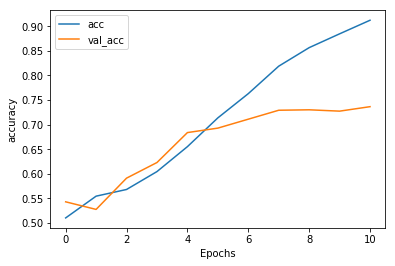

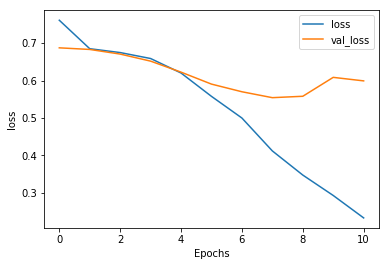

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
history = model1.fit(padded_sentences_train, trainY,
                    validation_data=(padded_sentences_dev, devY),
                    epochs=30,
                    batch_size=batch_size,
                    callbacks=[callback],
                    verbose = 0) #Early stopping to obtain best performing model on the validation data
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

<u>Note:</u> L2 regularization is not applied to this model since it penalizes the model heavily. The validation accuracy ends around 50% which is as good as random guess. On removing the hyperparameter, the model overfits on the training data but performs better on the validation data.

<b>Model 2: CNN-static</b>
<br>
Pre-trained GloVe embeddings are used but not updated during training.

In [25]:
#Model 2: CNN-static

convs = []

embedding_layer = Embedding(vocab_length,
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=length_long_sentence,
                            trainable=False)

sequence_input = keras.engine.input_layer.Input(shape=(length_long_sentence,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for cur_filter in cnn_filter_sizes:
    l_conv = Conv1D(filters=filter_map_size, kernel_size=cur_filter, activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(pool_size=length_long_sentence-cur_filter+1, strides=None, padding='valid')(l_conv)
    l_flatten = Flatten()(l_pool)
    convs.append(l_flatten)
    
output_layer = concatenate(convs, axis=-1)
output_layer = Dropout(dropout_p)(output_layer)
prediction_layer = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_s))(output_layer)

model2 = Model(inputs=sequence_input, outputs=prediction_layer)
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
print(model2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 56)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 56, 300)      5352000     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 54, 100)      90100       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 53, 100)      120100      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_14 

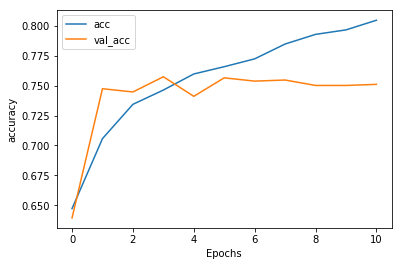

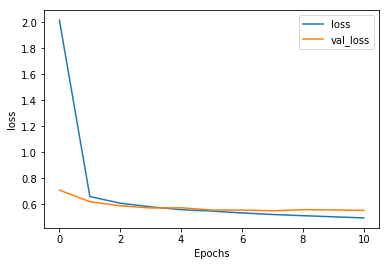

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
history = model2.fit(padded_sentences_train, trainY,
                    validation_data=(padded_sentences_dev, devY),
                    epochs=30,
                    batch_size=batch_size,
                    callbacks=[callback],
                    verbose = 0) #Early stopping to obtain best performing model on the validation data
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

<b>Model 3: CNN-non-static</b>
<br>
Pre-trained GloVe embeddings are used but and fine-tuned/updated during training.

In [27]:
#Model 3: CNN-non-static

convs = []

embedding_layer = Embedding(vocab_length,
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=length_long_sentence,
                            trainable=True)

sequence_input = keras.engine.input_layer.Input(shape=(length_long_sentence,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for cur_filter in cnn_filter_sizes:
    l_conv = Conv1D(filters=filter_map_size, kernel_size=cur_filter, activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(pool_size=length_long_sentence-cur_filter+1, strides=None, padding='valid')(l_conv)
    l_flatten = Flatten()(l_pool)
    convs.append(l_flatten)
    
output_layer = concatenate(convs, axis=-1)
output_layer = Dropout(dropout_p)(output_layer)
prediction_layer = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_s))(output_layer)

model3 = Model(inputs=sequence_input, outputs=prediction_layer)
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
print(model3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 56)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 56, 300)      5352000     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 54, 100)      90100       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 53, 100)      120100      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_17 

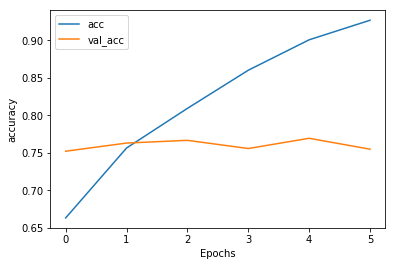

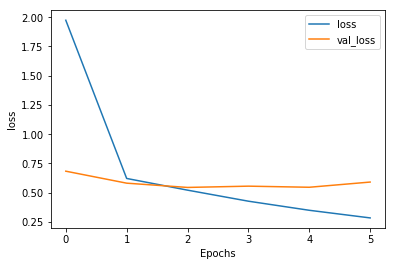

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
history = model3.fit(padded_sentences_train, trainY,
                    validation_data=(padded_sentences_dev, devY),
                    epochs=30,
                    batch_size=batch_size,
                    callbacks=[callback],
                    verbose = 0) #Early stopping to obtain best performing model on the validation data
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

<b>Obserations:</b>
<ul>
    <li>The best performing model is the third model with pre-trained embeddings that are fine-tuned during training. It registers a higher validation accuracy on the data and also converges faster. This indicates that fine-tuning the embeddings for the data at hand results in better performance since the embeddings are tuned to be better representatives of the corpus.</li>
    <li>Using pre-trained embeddings without updating them during training results in lesser performance.</li>
    <li>Randomly initialized weights result in the lowest performance though they are fine-tuned during training. Additionally, they result in overfitting. On penalizing the same, the performance decreases drastically.</li>
</ul>

<b>Evaluating the models on the test data</b>

In [32]:
#Evaluating CNN-rand on the test data
loss, accuracy, precision, recall = model1.evaluate(padded_sentences_test, testY, verbose=0)
print("Evaluating CNN-rand on test data")
displayMetrics(accuracy, precision, recall)

Evaluating CNN-rand on test data
Accuracy: 72.714931
Precision:  0.7171986
Recall: 0.7401647
F1-score: 0.7285006666131206


In [33]:
#Evaluating CNN-static on the test data
loss, accuracy, precision, recall = model2.evaluate(padded_sentences_test, testY, verbose=0)
print("Evaluating CNN-static on test data")
displayMetrics(accuracy, precision, recall)

Evaluating CNN-static on test data
Accuracy: 76.515836
Precision:  0.7749042
Recall: 0.7401647
F1-score: 0.7571361678989856


In [34]:
#Evaluating CNN-non-static on the test data
loss, accuracy, precision, recall = model3.evaluate(padded_sentences_test, testY, verbose=0)
print("Evaluating CNN-non-static on test data")
displayMetrics(accuracy, precision, recall)

Evaluating CNN-non-static on test data
Accuracy: 77.194571
Precision:  0.7599294
Recall: 0.7877402
F1-score: 0.7735848931747019


<b>Final observations:</b>
<ul>
    <li>The model with pre-trained vectors that are fine-tuned during training (model 3) performs the best on the validation and test datasets.</li>
    <li>The model with pre-trained vectors that aren't updated during training performs slightly worse than the third model. This could be considered as impact of model 3 performing well due to the word embeddings being adapted to the corpus during training.</li>
    <li>The first model, with random initialization, results in the least performance metrics.</li>
    <li>The CNN model, thus seem to benefit from using pre-trained word embeddings that are futher trained on the corpus to achieve best performance on the test data.</li>
</ul>